# Plot the Evaluation Rates
How many materials made it through each scale?

In [1]:
import pandas as pd
import numpy as np
import json
import re

from matplotlib import pyplot as plt
from scipy.stats import siegelslopes, linregress
from itertools import chain
from pathlib import Path

## Load the results
Get the results from the biggest scale, show how we compute the generation rate

In [2]:
path = Path("../prod-runs/450-nodes/")

### Generated Ligands
Start with the number of generated. We measure the number produced per batch using the "done" time as the time processing has completed

In [3]:
def load_generation(path: Path) -> pd.DataFrame:
    """Get the number of ligands produced a function of time

    Args:
        path: Path to the run directory
    Returns:
        Report of the number of ligands generated at each time point
    """

    # Get the number of ligands per task
    ligand_per_task = json.loads((path / "params.json").read_text())["gen_batch_size"]

    # Count the "process_ligand" tasks
    output = []
    with open(path / "generation-results.json") as fp:
        for line in fp:
            record = json.loads(line)
            if record["method"] == "process_ligands" and record["success"]:
                output.append(
                    {
                        "time": record["task_info"]["process_done"],
                        "num_made": ligand_per_task,
                    }
                )

    # Collect results
    output = pd.DataFrame(output)
    output["time"] -= output["time"].min()
    output.sort_values("time", inplace=True)
    output["total"] = output["num_made"].cumsum()
    return output


generated = load_generation(path)

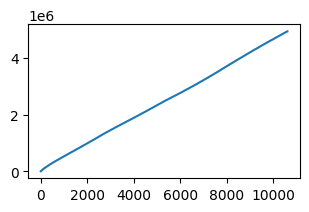

In [4]:
fig, ax = plt.subplots(figsize=(3.5, 2.0))

reg = linregress(generated["time"], generated["total"])
ax.step(generated["time"], generated["total"])

In [5]:
linregress(generated["time"], generated["total"])

LinregressResult(slope=458.09281063785374, intercept=55723.9837482851, rvalue=0.9998554350213725, pvalue=0.0, stderr=0.0396273325052025, intercept_stderr=242.9017496254465)

The result is very linear, so we can use standard linear regression

Determine the number which pass this step

In [6]:
process_re = re.compile(r"Received (\d+) \w+ ligands [\w\s]+, (\d+) \(")

In [7]:
total_made = total_valid = 0
with (path / "run.log").open() as fp:
    for line in fp:
        if (group := process_re.search(line)) is not None:
            made, valid = group.groups()
            total_made += int(made)
            total_valid += int(valid)

In [8]:
print(
    f"Made {total_made} linkers, {total_valid} ({total_valid / total_made * 100:.2f}%) are valid"
)

Made 4946944 linkers, 1131063 (22.86%) are valid


### Assembled MOFs
Use the results of the assembly tasks

In [9]:
def load_assembly(path: Path) -> pd.DataFrame:
    """Get the number of MOFs produced a function of time

    Args:
        path: Path to the run directory
    Returns:
        Report of the number of ligands generated at each time point
    """

    # Count the "process_ligand" tasks
    output = []
    with open(path / "assembly-results.json") as fp:
        for line in fp:
            record = json.loads(line)
            if record["success"]:
                output.append(
                    {
                        "time": record["timestamp"]["result_received"],
                        "num_made": record["task_info"]["to_make"],
                    }
                )

    # Collect results
    output = pd.DataFrame(output)
    output["time"] -= output["time"].min()
    output.sort_values("time", inplace=True)
    output["total"] = output["num_made"].cumsum()
    return output


assembled = load_assembly(path)

In [10]:
res = linregress(assembled["time"], assembled["total"])

Text(0, 0.5, 'Count')

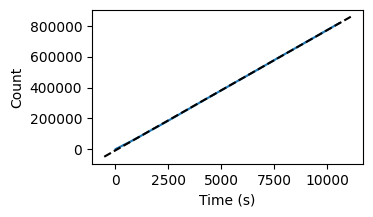

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.0))

ax.step(assembled["time"], assembled["total"])
ax.plot(ax.get_xlim(), np.multiply(res.slope, ax.get_xlim()) + res.intercept, "k--")

ax.set_xlabel("Time (s)")
ax.set_ylabel("Count")

Count the number made

In [12]:
assembled_re = re.compile(r"Created (\d+) new MOFs")

In [13]:
total_assembled = assembled["total"].max()

In [14]:
total_succeeded = 0
with (path / "run.log").open() as fp:
    for line in fp:
        if (group := assembled_re.search(line)) is not None:
            total_succeeded += int(group.groups()[0])

In [15]:
print(
    f"Assembled {total_assembled} MOFs. {total_assembled} ({total_succeeded / total_assembled * 100:.2f}%) passed quality control"
)

Assembled 818304 MOFs. 818304 (99.85%) passed quality control


## Stabilities Computed
Get the number of LAMMPS computations completed as a function of time

In [16]:
def load_lammps(path: Path) -> pd.DataFrame:
    """Get the number of MOFs through MD a function of time

    Args:
        path: Path to the run directory
    Returns:
        Report of the number of ligands generated at each time point
    """

    # Count the "process_ligand" tasks
    output = []
    with open(path / "simulation-results.json") as fp:
        for line in fp:
            record = json.loads(line)
            if record["method"] == "run_molecular_dynamics":
                output.append(
                    {
                        "time": record["timestamp"]["result_received"],
                        "num_made": 1 if record["success"] else 0,
                    }
                )

    # Collect results
    output = pd.DataFrame(output)
    output["time"] -= output["time"].min()
    output.sort_values("time", inplace=True)
    output["total"] = output["num_made"].cumsum()
    return output


lammps = load_lammps(path)

In [17]:
res = linregress(lammps["time"], lammps["total"])

Text(0, 0.5, 'Count')

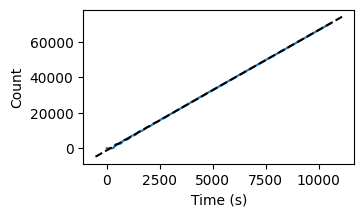

In [18]:
fig, ax = plt.subplots(figsize=(3.5, 2.0))

ax.step(lammps["time"], lammps["total"])
ax.plot(ax.get_xlim(), np.multiply(res.slope, ax.get_xlim()) + res.intercept, "k--")

ax.set_xlabel("Time (s)")
ax.set_ylabel("Count")

Count how many were attempted

In [19]:
total_md_started = len(lammps)
total_md_success = lammps["total"].max()

In [20]:
print(
    f"Attempted LAMMPS on {total_md_started} ({total_md_started / total_assembled * 100:.2f}%), succeeded on {total_md_success} ({total_md_success / total_assembled * 100:.2f}%)"
)

Attempted LAMMPS on 123702 (15.12%), succeeded on 70500 (8.62%)


## Gas Storage
From the RASPA finished

In [21]:
def load_raspa(path: Path) -> pd.DataFrame:
    """Get the number of MOFs through GCMC a function of time

    Args:
        path: Path to the run directory
    Returns:
        Report of the number of ligands generated at each time point
    """

    # Count the "process_ligand" tasks
    output = []
    with open(path / "simulation-results.json") as fp:
        for line in fp:
            record = json.loads(line)
            if record["success"] and record["method"] == "run_GCMC_single":
                output.append(
                    {
                        "time": record["timestamp"]["result_received"],
                        "num_made": 1,
                    }
                )

    # Collect results
    output = pd.DataFrame(output)
    output["time"] -= output["time"].min()
    output.sort_values("time", inplace=True)
    output["total"] = output["num_made"].cumsum()
    return output


raspa = load_raspa(path)

In [22]:
res = siegelslopes(raspa["total"], raspa["time"])

Text(0, 0.5, 'Count')

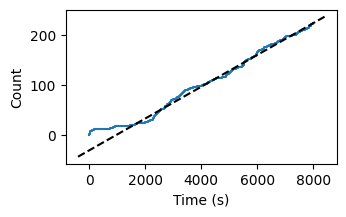

In [23]:
fig, ax = plt.subplots(figsize=(3.5, 2.0))

ax.step(raspa["time"], raspa["total"])
ax.plot(ax.get_xlim(), np.multiply(res.slope, ax.get_xlim()) + res.intercept, "k--")

ax.set_xlabel("Time (s)")
ax.set_ylabel("Count")

Count the screening fraction

In [24]:
print(f"Evaluated storage of {len(raspa)} ({len(raspa) / total_assembled *100:.2f}%)")

Evaluated storage of 224 (0.03%)


## Summarize Over Scale
Plot these results as a function of scale

In [25]:
runs = list(
    chain(
        Path("../prod-runs/").glob("*-nodes"),
        Path("../prod-runs/").glob("*-nodes_repeat-*"),
    )
)

In [26]:
summary = []
for path in runs:
    nodes = int(path.name.split("-")[0])
    me = {"name": path.name, "nodes": nodes}

    # Ones with linear regression
    for task, func in [
        ("DiffLinker", load_generation),
        ("Assembly", load_assembly),
        ("LAMMPS", load_lammps),
    ]:
        tasks = func(path)
        me[task + "-rate"] = linregress(tasks["time"], tasks["total"]).slope * 3600

    # Ones with sparse regression
    for task, func in [("CP2K+RASPA", load_raspa)]:
        tasks = func(path)
        me[task + "-rate"] = siegelslopes(tasks["total"], tasks["time"]).slope * 3600

    summary.append(me)
summary = pd.DataFrame(summary).sort_values("nodes")
summary

,name,nodes,DiffLinker-rate,Assembly-rate,LAMMPS-rate,CP2K+RASPA-rate
4,32-nodes_repeat-1,32,5.998298e+04,31655.763591,1917.031667,5.719428
6,32-nodes_repeat-2,32,7.880699e+04,31354.873685,1893.035318,7.396966
3,64-nodes_repeat-2,64,1.798089e+05,28550.652335,3709.933145,12.851617
5,64-nodes_repeat-1,64,1.801904e+05,30028.931713,3545.920710,17.054113
0,128-nodes,128,4.064778e+05,60282.054454,7018.797974,32.367186
1,256-nodes,256,8.792606e+05,151548.181768,14008.846510,68.104150
2,450-nodes,450,1.649134e+06,280278.829414,24401.898524,114.383164


Plot the scaling

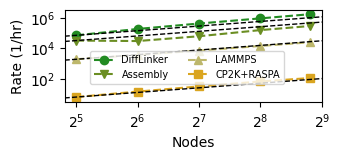

In [27]:
fig, ax = plt.subplots(figsize=(3.5, 1.7))

markers = iter(["o", "v", "^", "s"])
colors = iter(["forestgreen", "olivedrab", "darkkhaki", "goldenrod"])
for c in summary.columns:
    if not c.endswith("-rate"):
        continue
    subset = summary.groupby("nodes")[c].mean()
    task = c.split("-")[0]

    ax.loglog(
        subset.index, subset, "--", label=task, marker=next(markers), color=next(colors)
    )
    ax.set_xlim(ax.get_xlim())

    # Plot the ideal scaling line
    lowest_rate = subset.iloc[0]
    ideal = lowest_rate / subset.index.min()
    ax.plot(ax.get_xlim(), np.multiply(ideal, list(ax.get_xlim())), "k--", lw=1)

ax.set_xscale("log", base=2)
ax.set_xlabel("Nodes")
ax.set_ylabel("Rate (1/hr)")
ax.legend(ncol=2, fontsize=7, loc=(0.1, 0.2))

fig.tight_layout()
# fig.savefig('figures/task-rates-by-scale.png', dpi=320)
# fig.savefig('figures/task-rates-by-scale.pdf', dpi=320)
plt.show()

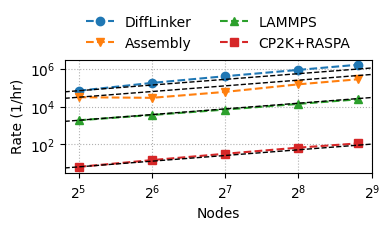

In [41]:
fig, ax = plt.subplots(figsize=(4, 3))

markers = iter(["o", "v", "^", "s"])
colors = iter(["tab:blue", "tab:orange", "tab:green", "tab:red"])
for c in summary.columns:
    if not c.endswith("-rate"):
        continue
    subset = summary.groupby("nodes")[c].mean()
    task = c.split("-")[0]

    ax.loglog(
        subset.index, subset, "--", label=task, marker=next(markers), color=next(colors)
    )
    ax.set_xlim(ax.get_xlim())

    # Plot the ideal scaling line
    lowest_rate = subset.iloc[0]
    ideal = lowest_rate / subset.index.min()
    ax.plot(ax.get_xlim(), np.multiply(ideal, list(ax.get_xlim())), "k--", lw=1)

ax.set_xscale("log", base=2)
ax.set_xlabel("Nodes")
ax.set_ylabel("Rate (1/hr)")
ax.legend(
    ncol=2,
    frameon=False,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.5),
)

plt.grid(linestyle=":")

fig.tight_layout()
plt.savefig("figures/fig5.pdf", bbox_inches="tight")
plt.show()